1단계: 데이터 속성 정보 확인
2단계: 패치 추출
3단계: 추출된 패치 확인

In [21]:
import os
import matplotlib.pyplot as plt
import numpy as np
import argparse
import json
import seaborn as sns
import pandas as pd
from esa_snappy import ProductIO, GPF, HashMap



## 1. 전처리된 데이터 형태 및 특성 확인하기

In [22]:
# ── 데이터 shape 확인 셀 (readPixels 버전) ──
from pathlib import Path
from esa_snappy import ProductIO
import numpy as np

# 1) .dim 파일 열기
dim_path = Path(r"D:\Sentinel-1\data\buffer").glob("*mrg.dim").__next__()
prod     = ProductIO.readProduct(str(dim_path))

# 2) 전체 이미지 크기 출력
width, height = prod.getSceneRasterWidth(), prod.getSceneRasterHeight()
print(f"전체 이미지 크기: width={width} px, height={height} px")

# 3) 밴드 이름 목록 가져와 Python 리스트로 변환
bands_java = prod.getBandNames()
bands = [str(b) for b in bands_java]
print("사용 가능한 밴드들:")
for name in bands:
    print("  -", name)

# 4) 샘플 윈도우 정의 및 중심점 계산
w0, h0 = 0, 0
w_win, h_win = 100, 100
cx, cy = width // 2, height // 2  # 이미지 중심점 좌표

print(f"이미지 중심점: ({cx}, {cy})")

# 5) NumPy 1D 버퍼 준비 (float32)
sample = np.zeros((len(bands), h_win, w_win), dtype=np.float32)
buf = np.empty(w_win * h_win, dtype=np.float32)

# 5) 버퍼 준비
bands = [str(b) for b in prod.getBandNames()]
buf   = np.empty(w_win * h_win, dtype=np.float32)
sample = np.zeros((len(bands), h_win, w_win), dtype=np.float32)

# 6) 중앙에서 샘플 읽기
for i, name in enumerate(bands):
    band = prod.getBand(name)
    band.readPixels(cx - w_win//2, cy - h_win//2, w_win, h_win, buf)
    sample[i] = buf.reshape(h_win, w_win)

# 7) 결과 확인
print(f"샘플 위치: 중심({cx}, {cy})")
print("샘플 윈도우 배열 shape:", sample.shape)
print("샘플 값 범위: min =", float(sample.min()), ", max =", float(sample.max()))

전체 이미지 크기: width=67318 px, height=13595 px
사용 가능한 밴드들:
  - i_VH
  - q_VH
  - i_VV
  - q_VV
  - Intensity_VH
  - Intensity_VV
이미지 중심점: (33659, 6797)
샘플 위치: 중심(33659, 6797)
샘플 윈도우 배열 shape: (6, 100, 100)
샘플 값 범위: min = -1.6475818157196045 , max = 5.202110767364502


## 2. 패치 추출 함수 정의하기

In [23]:
# High-performance patch extraction setup

import numpy as np, torch, torch.nn.functional as F, json, time, gc, os
from pathlib import Path
from typing import Tuple, List, Optional, Dict
from esa_snappy import ProductIO
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed
import re

# Optional GPU acceleration for FFT
try:
    import cupy as cp; HAS_CUPY = True
except ImportError:
    cp = None; HAS_CUPY = False

# Patch and stride dimensions
PATCH_H, PATCH_W = 512, 256
STRIDE_Y, STRIDE_X = 512, 256
POL_ORDER = ['VV', 'VH']
SAVE_BASE = Path(r"D:\Sentinel-1\data\patches")
SAVE_BASE.mkdir(parents=True, exist_ok=True)

print("Patch extraction system configured.")
print(f"  Patch size: {PATCH_H}x{PATCH_W}")
print(f"  Stride: {STRIDE_Y}x{STRIDE_X}")
print(f"  Save directory: {SAVE_BASE}")
print(f"  CPU cores: {os.cpu_count()}")
print(f"  GPU acceleration: {'Enabled' if HAS_CUPY else 'Disabled'}")

Patch extraction system configured.
  Patch size: 512x256
  Stride: 512x256
  Save directory: D:\Sentinel-1\data\patches
  CPU cores: 20
  GPU acceleration: Enabled


In [26]:
import re
import os
from tqdm import tqdm
from typing import List, Tuple, Dict, Optional

def find_band_pattern(band_names: List[str], patterns: List[str]) -> Optional[str]:
    """Finds a band name matching a list of regex patterns."""
    for pattern in patterns:
        for name in band_names:
            if re.search(pattern, name, re.IGNORECASE):
                return name
    return None

def get_complex_pair(pol: str, band_names: List[str]) -> Tuple[str, str]:
    """Finds the real and imaginary band pair for a given polarization."""
    i_patterns = [rf"^i_{pol}$", rf"^i_IW\d+_{pol}$", rf"^real.*{pol}.*", rf"^i_.*{pol}.*"]
    q_patterns = [rf"^q_{pol}$", rf"^q_IW\d+_{pol}$", rf"^imag.*{pol}.*", rf"^q_.*{pol}.*"]
    
    i_band = find_band_pattern(band_names, i_patterns)
    q_band = find_band_pattern(band_names, q_patterns)
    
    if not i_band or not q_band:
        raise ValueError(f"Cannot find complex pair for {pol}. Available bands: {band_names}")
    
    return i_band, q_band

def extract_patches_single_file(dim_path: Path) -> Tuple[str, int, int]:
    """
    Extracts patches from a single .dim file with a stable patch-by-patch reading method.
    Returns: (filename, extracted_count, skipped_count)
    """
    try:
        from esa_snappy import ProductIO
        import numpy as np
        import gc

        prod = ProductIO.readProduct(str(dim_path))
        width, height = prod.getSceneRasterWidth(), prod.getSceneRasterHeight()
        band_names = [str(b) for b in prod.getBandNames()]

        vv_i_name, vv_q_name = get_complex_pair("VV", band_names)
        vh_i_name, vh_q_name = get_complex_pair("VH", band_names)

        vv_i_band = prod.getBand(vv_i_name)
        vv_q_band = prod.getBand(vv_q_name)
        vh_i_band = prod.getBand(vh_i_name)
        vh_q_band = prod.getBand(vh_q_name)

        scene_dir = SAVE_BASE / dim_path.stem
        scene_dir.mkdir(parents=True, exist_ok=True)

        coords_to_process = []
        skipped = 0
        for y in range(0, height - PATCH_H + 1, STRIDE_Y):
            for x in range(0, width - PATCH_W + 1, STRIDE_X):
                out_path = scene_dir / f"{dim_path.stem}_dual_pol_complex_{x}_{y}.npy"
                if out_path.exists():
                    skipped += 1
                else:
                    coords_to_process.append({'x': x, 'y': y, 'path': out_path})
        
        if not coords_to_process:
            prod.dispose()
            return (dim_path.name, 0, skipped)

        patch_buf_size = PATCH_W * PATCH_H
        buf_i = np.empty(patch_buf_size, dtype=np.float32)
        buf_q = np.empty(patch_buf_size, dtype=np.float32)
        
        extracted = 0
        with tqdm(total=len(coords_to_process), desc=f"Extracting from {dim_path.name}", leave=False) as pbar:
            for coord in coords_to_process:
                x, y, out_path = coord['x'], coord['y'], coord['path']
                
                vv_i_band.readPixels(x, y, PATCH_W, PATCH_H, buf_i)
                vv_q_band.readPixels(x, y, PATCH_W, PATCH_H, buf_q)
                vv = (buf_i.reshape(PATCH_H, PATCH_W) + 1j * buf_q.reshape(PATCH_H, PATCH_W)).astype(np.complex64)
                
                vh_i_band.readPixels(x, y, PATCH_W, PATCH_H, buf_i)
                vh_q_band.readPixels(x, y, PATCH_W, PATCH_H, buf_q)
                vh = (buf_i.reshape(PATCH_H, PATCH_W) + 1j * buf_q.reshape(PATCH_H, PATCH_W)).astype(np.complex64)
                
                patch = np.stack([vv, vh], axis=0)
                np.save(out_path, patch)
                extracted += 1
                pbar.update(1)
        
        prod.dispose()
        gc.collect()
        return (dim_path.name, extracted, skipped)

    except Exception as e:
        print(f"Error processing {dim_path.name}: {e}")
        return (dim_path.name, 0, 0)

### 2.1. 열화 모델 정의하기

In [27]:
def degrade_hr_to_lr(hr: np.ndarray, scale: int = 4) -> np.ndarray:
    """
    hr : (2,512,256) complex64 → (2,128,64) complex64
    방법: 복소 전력 평균 + 위상 평균 (train.py와 동일 로직)
    """
    use_gpu = (HAS_CUPY or torch.cuda.is_available())
    xp = cp if (HAS_CUPY and use_gpu) else np
    
    hr_x = xp.asarray(hr)
    amp = xp.sqrt(xp.mean(xp.abs(hr_x)**2, axis=(-2, -1), keepdims=True))
    # 1) 전력합→평균
    kernel = (scale, scale)
    power = xp.abs(hr_x)**2
    power_lr = power.reshape(2,
                             hr.shape[1]//scale, scale,
                             hr.shape[2]//scale, scale).sum(axis=(2,4))
    amp_lr = xp.sqrt(power_lr)
    # 2) 위상 평균
    phase = xp.angle(hr_x)
    phase_lr = xp.arctan2(
        xp.sin(phase).reshape(2, hr.shape[1]//scale, scale, hr.shape[2]//scale, scale).mean(axis=(2,4)),
        xp.cos(phase).reshape(2, hr.shape[1]//scale, scale, hr.shape[2]//scale, scale).mean(axis=(2,4))
    )
    lr = amp_lr * xp.exp(1j*phase_lr)
    return xp.asnumpy(lr).astype(np.complex64)


## 3. 패치 추출 실행 코드

In [28]:
def run_pipeline_stable(dim_paths, create_lr: bool = False, use_multiprocessing: bool = False):
    """
    Stable high-performance patch extraction pipeline.
    - dim_paths: List of .dim file paths or a single path.
    - create_lr: Whether to generate LR patches.
    - use_multiprocessing: Use multiprocessing (default False for stability).
    """
    start_time = time.time()
    
    if isinstance(dim_paths, (str, Path)):
        dim_paths = [Path(dim_paths)]
    else:
        dim_paths = [Path(p) for p in dim_paths]
    
    print(f"Starting stable patch extraction for {len(dim_paths)} files.")
    print(f"Mode: {'Multiprocessing' if use_multiprocessing else 'Sequential (stable)'}")
    
    all_patches = []
    
    if use_multiprocessing:
        all_patches = extract_patches_from_dim_high_performance(dim_paths, max_workers=4)
    else:
        total_extracted = 0
        total_skipped = 0
        
        for i, dim_path in enumerate(dim_paths, 1):
            print(f"\nProcessing [{i}/{len(dim_paths)}]: {dim_path.name}")
            
            try:
                filename, extracted, skipped = extract_patches_single_dim_stable(dim_path)
                total_extracted += extracted
                total_skipped += skipped
                
                print(f"Completed {filename}: {extracted} extracted, {skipped} skipped.")
                
                scene_dir = SAVE_BASE / dim_path.stem 
                if scene_dir.exists():
                    patches = list(scene_dir.glob("*_dual_pol_complex_*.npy"))
                    all_patches.extend(patches)
                    
            except Exception as e:
                print(f"Failed to process {dim_path.name}: {e}")
                continue
        
        print(f"\nSequential processing complete.")
        print(f"Total extracted: {total_extracted:,}, Total skipped: {total_skipped:,}")
    
    if create_lr and all_patches:
        print(f"\nGenerating LR patches for {len(all_patches)} files...")
        lr_created = 0
        
        for hr_path in tqdm(all_patches, desc="LR patch generation"):
            lr_path = hr_path.with_name(hr_path.name.replace("dual_pol_complex", "lr_complex"))
            
            if lr_path.exists():
                continue
                
            try:
                hr = np.load(hr_path)
                lr = degrade_hr_to_lr(hr)
                np.save(lr_path, lr)
                lr_created += 1
            except Exception as e:
                print(f"Failed to create LR patch for {hr_path.name}: {e}")
                continue
        
        print(f"Created {lr_created} new LR patches.")
    
    elapsed = time.time() - start_time
    print(f"\nTotal pipeline finished in {elapsed:.1f} seconds.")
    print(f"Total HR patches: {len(all_patches):,}")
    
    return all_patches

def extract_patches_single_dim_stable(dim_path: Path) -> Tuple[str, int, int]:
    """
    Stable single .dim file patch extraction without multiprocessing.
    """
    try:
        prod = ProductIO.readProduct(str(dim_path))
        width, height = prod.getSceneRasterWidth(), prod.getSceneRasterHeight()
        
        print(f"  Image size: {width} x {height}")
        
        band_names = [str(b) for b in prod.getBandNames()]
        
        try:
            vv_i_name, vv_q_name = get_complex_pair("VV", band_names)
            vh_i_name, vh_q_name = get_complex_pair("VH", band_names) 
            print(f"  VV bands: {vv_i_name}, {vv_q_name}")
            print(f"  VH bands: {vh_i_name}, {vh_q_name}")
        except ValueError as e:
            print(f"  Band matching failed: {e}")
            prod.dispose()
            return (dim_path.name, 0, 0)
        
        vv_i_band = prod.getBand(vv_i_name)
        vv_q_band = prod.getBand(vv_q_name)
        vh_i_band = prod.getBand(vh_i_name)
        vh_q_band = prod.getBand(vh_q_name)
        
        scene_dir = SAVE_BASE / dim_path.stem
        scene_dir.mkdir(parents=True, exist_ok=True)
        print(f"  Save directory: {scene_dir}")
        
        extracted = 0
        skipped = 0
        
        patches_y = (height - PATCH_H) // STRIDE_Y + 1
        patches_x = (width - PATCH_W) // STRIDE_X + 1
        total_patches = patches_y * patches_x
        print(f"  Estimated patches: {total_patches}")
        
        with tqdm(total=patches_y, desc="  Stripe processing", leave=False) as pbar:
            for y_idx, y_start in enumerate(range(0, height - PATCH_H + 1, STRIDE_Y)):
                stripe_h = min(PATCH_H, height - y_start)
                
                stripe_buf_size = width * stripe_h
                vv_i_buf = np.empty(stripe_buf_size, dtype=np.float32)
                vv_q_buf = np.empty(stripe_buf_size, dtype=np.float32) 
                vh_i_buf = np.empty(stripe_buf_size, dtype=np.float32)
                vh_q_buf = np.empty(stripe_buf_size, dtype=np.float32)
                
                vv_i_band.readPixels(0, y_start, width, stripe_h, vv_i_buf)
                vv_q_band.readPixels(0, y_start, width, stripe_h, vv_q_buf)
                vh_i_band.readPixels(0, y_start, width, stripe_h, vh_i_buf)
                vh_q_band.readPixels(0, y_start, width, stripe_h, vh_q_buf)
                
                vv_i_stripe = vv_i_buf.reshape(stripe_h, width)
                vv_q_stripe = vv_q_buf.reshape(stripe_h, width) 
                vh_i_stripe = vh_i_buf.reshape(stripe_h, width)
                vh_q_stripe = vh_q_buf.reshape(stripe_h, width)
                
                for x_start in range(0, width - PATCH_W + 1, STRIDE_X):
                    out_path = scene_dir / f"{dim_path.stem}_dual_pol_complex_{x_start}_{y_start}.npy"
                    
                    if out_path.exists():
                        skipped += 1
                        continue
                    
                    x_end = x_start + PATCH_W
                    vv_i_patch = vv_i_stripe[:PATCH_H, x_start:x_end]
                    vv_q_patch = vv_q_stripe[:PATCH_H, x_start:x_end]
                    vh_i_patch = vh_i_stripe[:PATCH_H, x_start:x_end] 
                    vh_q_patch = vh_q_stripe[:PATCH_H, x_start:x_end]
                    
                    vv_complex = (vv_i_patch + 1j * vv_q_patch).astype(np.complex64)
                    vh_complex = (vh_i_patch + 1j * vh_q_patch).astype(np.complex64)
                    patch = np.stack([vv_complex, vh_complex], axis=0)
                    
                    np.save(out_path, patch)
                    extracted += 1
                
                pbar.update(1)
        
        prod.dispose()
        gc.collect()
        
        return (dim_path.name, extracted, skipped)
        
    except Exception as e:
        print(f"  Error during processing: {e}")
        return (dim_path.name, 0, 0)

# Compatibility wrappers
def run_pipeline_ultra_fast(dim_paths, create_lr: bool = False, max_workers: Optional[int] = None):
    """Redirects to the stable version."""
    return run_pipeline_stable(dim_paths, create_lr=create_lr, use_multiprocessing=False)

def run_pipeline_optimized(dim_path: str, create_lr: bool = False):
    """Compatibility wrapper."""
    return run_pipeline_stable([dim_path], create_lr=create_lr, use_multiprocessing=False)

def run_pipeline(dim_path: str):
    """Original compatibility wrapper."""
    return run_pipeline_optimized(dim_path, create_lr=False)

def run_batch_pipeline_ultra_fast(dim_dir: str, pattern: str = "*mrg.dim", 
                                  create_lr: bool = False, max_workers: Optional[int] = None):
    """
    Processes all files in a directory sequentially and stably.
    """
    dim_dir = Path(dim_dir)
    dim_files = list(dim_dir.glob(pattern))
    
    if not dim_files:
        print(f"No files found in {dim_dir} matching '{pattern}'.")
        return []
    
    print(f"Found {len(dim_files)} files to process.")
    
    return run_pipeline_stable(dim_files, create_lr=create_lr, use_multiprocessing=False)

# Example execution
print("=" * 60)
print("Starting single file processing (stable mode):")
single_result = run_pipeline_stable(
    r"D:\Sentinel-1\data\buffer\S1B_IW_SLC__1SDV_20200825T213135_20200825T213203_023085_02BD50_0B18_Orb_Cal_Deb_mrg.dim",
    use_multiprocessing=False
)

# Example for batch processing (uncomment to use)
# print("\n" + "=" * 60) 
# print("Starting batch processing (stable mode):")
# batch_result = run_batch_pipeline_ultra_fast(
#     r"D:\Sentinel-1\data\buffer", 
#     "*mrg.dim", 
#     create_lr=False
# )

Starting single file processing (stable mode):
Starting stable patch extraction for 1 files.
Mode: Sequential (stable)

Processing [1/1]: S1B_IW_SLC__1SDV_20200825T213135_20200825T213203_023085_02BD50_0B18_Orb_Cal_Deb_mrg.dim
  Image size: 67318 x 13595
  VV bands: i_VV, q_VV
  VH bands: i_VH, q_VH
  Save directory: D:\Sentinel-1\data\patches\S1B_IW_SLC__1SDV_20200825T213135_20200825T213203_023085_02BD50_0B18_Orb_Cal_Deb_mrg
  Estimated patches: 6812


Completed S1B_IW_SLC__1SDV_20200825T213135_20200825T213203_023085_02BD50_0B18_Orb_Cal_Deb_mrg.dim: 6812 extracted, 0 skipped.

Sequential processing complete.
Total extracted: 6,812, Total skipped: 0

Total pipeline finished in 1516.6 seconds.
Total HR patches: 6,812


### 2.2. 패치 별 통계 확인하기

총 패치 개수: 6,645


Calculating patch statistics: 100%|██████████| 6645/6645 [04:35<00:00, 24.10it/s]


통계 계산 완료. DataFrame 샘플:
                                                path    mu_amp    sd_amp  \
0  D:\Sentinel-1\data\patches\zero_filtered\2020_...  0.014631  0.045926   
1  D:\Sentinel-1\data\patches\zero_filtered\2020_...  0.112937  0.088068   
2  D:\Sentinel-1\data\patches\zero_filtered\2020_...  0.292091  0.262480   
3  D:\Sentinel-1\data\patches\zero_filtered\2020_...  0.257859  0.229232   
4  D:\Sentinel-1\data\patches\zero_filtered\2020_...  0.236704  0.206327   

    p_valid  mu_phase_vv  sd_phase_vv  
0  0.142349     0.001749     0.690113  
1  0.998577    -0.759845     1.809434  
2  0.999767     1.135662     1.813041  
3  0.999775     0.290110     1.811899  
4  0.999676     1.129344     1.814770  

--- Amplitude Visualization ---


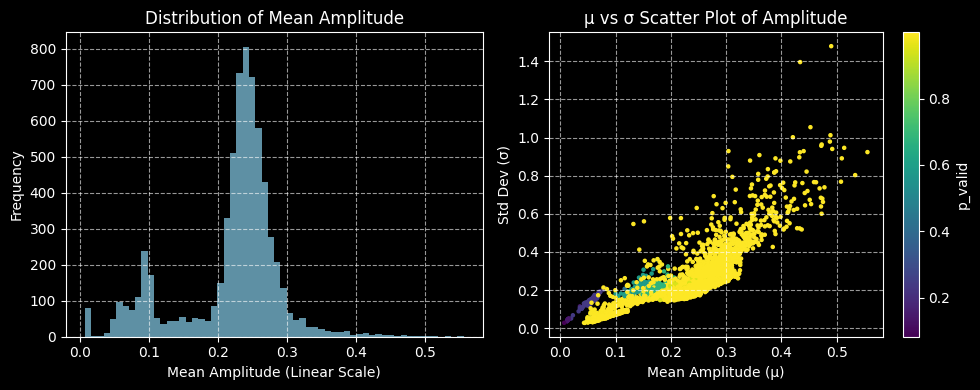


--- Phase Visualization (VV Polarization) ---


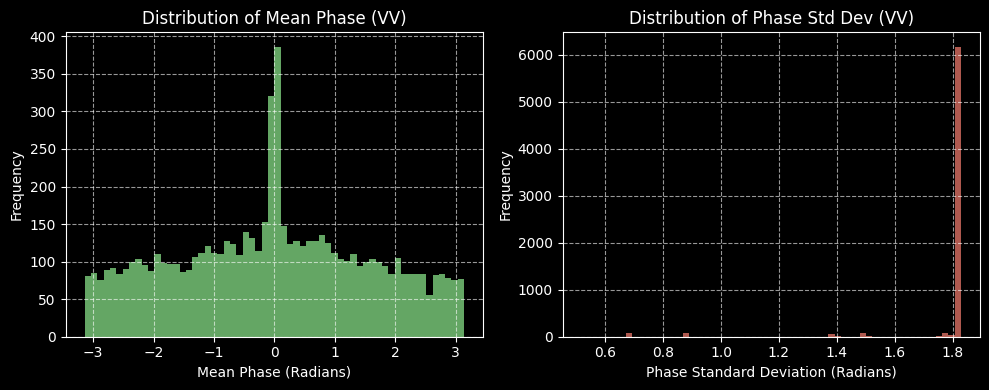


--- Amplitude vs. Phase Visualization ---


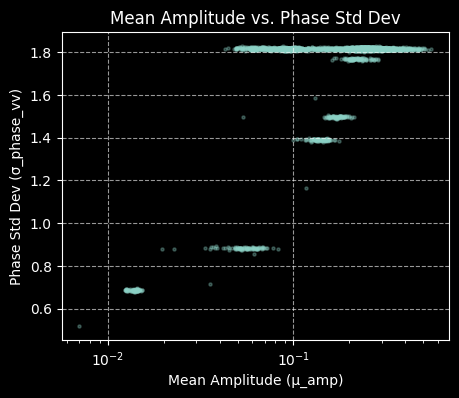

In [31]:
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

PATCH_DIR = Path(r"D:\Sentinel-1\data\patches\zero_filtered\2020_08_25(0B18)")
PATCH_LIST = sorted(PATCH_DIR.rglob("*_dual_pol_complex_*.npy"))
print(f"총 패치 개수: {len(PATCH_LIST):,}")

def patch_stats(path, eps=1e-6):
    """복소 패치에서 진폭과 위상의 통계(평균, 표준편차)를 계산합니다."""
    z = np.load(path)                       # (2, 512, 256) complex64
    
    # --- 진폭(Amplitude) 통계 ---
    amp = np.abs(z)
    mu_amp  = float(amp.mean())
    sd_amp  = float(amp.std())
    p_valid = float((amp > eps).mean())
    
    # --- 위상(Phase) 통계 ---
    phase = np.angle(z) # 라디안 단위 (-π ~ +π)
    
    # 위상 평균은 벡터 평균으로 계산하여 wrap-around 문제 해결
    mean_phasor_vv = np.mean(np.exp(1j * phase[0, :, :]))
    mu_phase_vv = np.angle(mean_phasor_vv)
    
    # 위상 표준편차는 각 편파별로 계산
    sd_phase_vv = float(phase[0, :, :].std())
    
    return mu_amp, sd_amp, p_valid, mu_phase_vv, sd_phase_vv

rows = []
for p in tqdm(PATCH_LIST, desc="Calculating patch statistics"):
    mu_amp, sd_amp, p_valid, mu_phase_vv, sd_phase_vv = patch_stats(p)
    rows.append({
        "path": str(p), 
        "mu_amp": mu_amp, "sd_amp": sd_amp, "p_valid": p_valid,
        "mu_phase_vv": mu_phase_vv, "sd_phase_vv": sd_phase_vv
    })

df = pd.DataFrame(rows)
df.to_csv(PATCH_DIR / "patch_statistics_with_phase.csv", index=False)
print("통계 계산 완료. DataFrame 샘플:")
print(df.head())


# --- 1. 진폭(Amplitude) 시각화 ---
print("\n--- Amplitude Visualization ---")
plt.figure(figsize=(10, 4))

# 진폭 평균 히스토그램
plt.subplot(1, 2, 1)
plt.hist(df["mu_amp"], bins=60, alpha=0.7, color='skyblue')
plt.xlabel("Mean Amplitude (Linear Scale)")
plt.ylabel("Frequency")
plt.title("Distribution of Mean Amplitude")
plt.grid(True, linestyle='--', alpha=0.6)

# 진폭 평균 vs 표준편차 산점도
plt.subplot(1, 2, 2)
plt.scatter(df["mu_amp"], df["sd_amp"], c=df["p_valid"], s=5, cmap="viridis")
plt.colorbar(label="p_valid")
plt.xlabel("Mean Amplitude (μ)")
plt.ylabel("Std Dev (σ)")
plt.title("μ vs σ Scatter Plot of Amplitude")
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig(PATCH_DIR / "patch_amplitude_stats.png", dpi=300)
plt.show()



# --- 2. 위상(Phase) 시각화 (VV 편파 기준) ---
print("\n--- Phase Visualization (VV Polarization) ---")
plt.figure(figsize=(10, 4))

# 위상 평균 히스토그램
plt.subplot(1, 2, 1)
plt.hist(df["mu_phase_vv"], bins=60, alpha=0.7, color='lightgreen')
plt.xlabel("Mean Phase (Radians)")
plt.ylabel("Frequency")
plt.title("Distribution of Mean Phase (VV)")
plt.grid(True, linestyle='--', alpha=0.6)

# 위상 표준편차 히스토그램
plt.subplot(1, 2, 2)
plt.hist(df["sd_phase_vv"], bins=60, alpha=0.7, color='salmon')
plt.xlabel("Phase Standard Deviation (Radians)")
plt.ylabel("Frequency")
plt.title("Distribution of Phase Std Dev (VV)")
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig(PATCH_DIR / "patch_phase_stats_vv.png", dpi=300)
plt.show()



# --- 3. 진폭-위상 관계 시각화 ---
print("\n--- Amplitude vs. Phase Visualization ---")
plt.figure(figsize=(5, 4))
plt.scatter(df["mu_amp"], df["sd_phase_vv"], s=5, alpha=0.3)
plt.xlabel("Mean Amplitude (μ_amp)")
plt.ylabel("Phase Std Dev (σ_phase_vv)")
plt.title("Mean Amplitude vs. Phase Std Dev")
plt.grid(True, linestyle='--', alpha=0.6)
# 진폭 축을 로그 스케일로 변경하여 분포를 더 잘 확인
try:
    plt.xscale('log')
except ValueError: # 데이터에 0 또는 음수가 있을 경우를 대비
    pass
plt.savefig(PATCH_DIR / "patch_amp_vs_phase_scatter.png", dpi=300)
plt.show()


## 패치 별 이상치 필터링하는 함수

In [30]:
import shutil
from pathlib import Path
import numpy as np
from tqdm import tqdm
import json
import re

# --- 설정 ---
# 원본 패치가 있는 디렉터리
SOURCE_PATCH_DIR = Path(r"D:\Sentinel-1\data\patches\S1B_IW_SLC__1SDV_20200825T213135_20200825T213203_023085_02BD50_0B18_Orb_Cal_Deb_mrg")

# 필터링된 '좋은' 패치를 저장할 새 디렉터리
DEST_PATCH_DIR = Path(r"D:\Sentinel-1\data\patches\zero_filtered\2020_08_25(0B18)")
DEST_PATCH_DIR.mkdir(parents=True, exist_ok=True)

# 필터링 로그 파일 (제거된 패치 정보 기록)
REMOVED_JSON_PATH = DEST_PATCH_DIR / "patch_removed_list.json"

# --- 필터링 로직 ---
# 유효 픽셀이 하나라도 있는지 확인할 때 사용할 작은 값
EPSILON = 1e-7

# --- 실행 ---
source_files = sorted(SOURCE_PATCH_DIR.glob("*_dual_pol_complex_*.npy"))
kept_count = 0
removed_files_info = []

print(f"총 {len(source_files):,}개의 패치를 대상으로 필터링을 시작합니다.")
print(f"결과는 '{DEST_PATCH_DIR}'에 저장됩니다.")

# 파일 이름에서 좌표를 추출하기 위한 정규식
coord_regex = re.compile(r"_(\d+)_(\d+)\.npy$")

for npy_path in tqdm(source_files, desc="Filtering zero-padded patches"):
    z = np.load(npy_path)
    amp = np.abs(z)
    
    # 유효 픽셀(진폭 > EPSILON)의 비율 계산
    p_valid = (amp > EPSILON).mean()
    
    # ★ 필터링 규칙: 유효 픽셀이 하나라도 있으면 (p_valid > 0) '유효한 패치'로 판단하여 복사
    if p_valid > 0:
        dest_path = DEST_PATCH_DIR / npy_path.name
        shutil.copy(npy_path, dest_path)
        kept_count += 1
    else:
        # 제로패딩 패치인 경우 (p_valid == 0), 정보를 기록
        match = coord_regex.search(npy_path.name)
        if match:
            x, y = map(int, match.groups())
            removed_files_info.append({
                "path": str(npy_path),
                "x": x,
                "y": y
            })

# 제거된 패치 정보 기록
with open(REMOVED_JSON_PATH, "w") as f:
    json.dump(removed_files_info, f, indent=2)

print("\n필터링 완료!")
print(f"  - 유지된 패치: {kept_count:,} 개")
print(f"  - 제거된 제로패딩 패치: {len(removed_files_info):,} 개")
print(f"  - 제거된 패치 정보 저장: '{REMOVED_JSON_PATH}'")

총 6,812개의 패치를 대상으로 필터링을 시작합니다.
결과는 'D:\Sentinel-1\data\patches\zero_filtered\2020_08_25(0B18)'에 저장됩니다.


Filtering zero-padded patches: 100%|██████████| 6812/6812 [08:07<00:00, 13.99it/s]


필터링 완료!
  - 유지된 패치: 6,645 개
  - 제거된 제로패딩 패치: 167 개
  - 제거된 패치 정보 저장: 'D:\Sentinel-1\data\patches\zero_filtered\2020_08_25(0B18)\patch_removed_list.json'


### 제거된 패치 분포 시각화

제거된 패치 167개의 정보를 로드했습니다.
원본 이미지 크기: 67318 x 13595


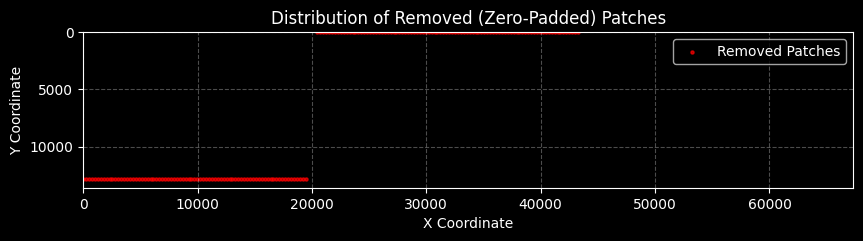

In [32]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from esa_snappy import ProductIO

# --- 분석 설정 ---
# 필터링 결과 JSON 파일 경로
REMOVED_JSON_PATH = Path(r"D:\Sentinel-1\data\patches\zero_filtered\2020_08_25(0B18)\patch_removed_list.json")

# 원본 DIM 파일 경로 (전체 이미지 크기를 얻기 위함)
ORIGINAL_DIM_PATH = Path(r"D:\Sentinel-1\data\buffer\S1B_IW_SLC__1SDV_20200825T213135_20200825T213203_023085_02BD50_0B18_Orb_Cal_Deb_mrg.dim")

# --- 데이터 로드 및 시각화 ---
if not REMOVED_JSON_PATH.exists():
    print(f"❌ 분석할 파일이 없습니다: '{REMOVED_JSON_PATH}'")
    print("필터링 셀을 먼저 실행해주세요.")
else:
    # 1. 제거된 패치 데이터 로드
    df_removed = pd.read_json(REMOVED_JSON_PATH)
    print(f"제거된 패치 {len(df_removed)}개의 정보를 로드했습니다.")
    
    # 2. 원본 이미지 크기 정보 읽기
    try:
        prod = ProductIO.readProduct(str(ORIGINAL_DIM_PATH))
        width = prod.getSceneRasterWidth()
        height = prod.getSceneRasterHeight()
        prod.dispose()
        print(f"원본 이미지 크기: {width} x {height}")

        # 3. 분포 시각화
        plt.style.use('dark_background')
        fig, ax = plt.subplots(figsize=(10, 10 * height / width))
        
        ax.scatter(df_removed['x'], df_removed['y'], s=5, alpha=0.7, color='red', label='Removed Patches')
        
        ax.set_title('Distribution of Removed (Zero-Padded) Patches')
        ax.set_xlabel('X Coordinate')
        ax.set_ylabel('Y Coordinate')
        ax.set_xlim(0, width)
        ax.set_ylim(height, 0) # 이미지 좌표계처럼 위쪽을 0으로 설정
        ax.set_aspect('equal', adjustable='box')
        ax.grid(True, linestyle='--', alpha=0.3)
        ax.legend()
        
        plt.show()

    except Exception as e:
        print(f"원본 .dim 파일을 읽는 중 오류 발생: {e}")


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(hr_path: Path):
    hr = np.load(hr_path)
    lr = np.load(hr_path.with_name(hr_path.name.replace("dual_pol_complex", "lr_complex")))
    
    fig, ax = plt.subplots(2, 2, figsize=(8,6))
    ax[0,0].imshow(20*np.log10(np.abs(hr[0])+1e-6)); ax[0,0].set_title("HR VV Amp")
    ax[0,1].imshow(np.angle(hr[0]), cmap='twilight'); ax[0,1].set_title("HR VV Phase")
    ax[1,0].imshow(20*np.log10(np.abs(lr[0])+1e-6)); ax[1,0].set_title("LR VV Amp")
    ax[1,1].imshow(np.angle(lr[0]), cmap='twilight'); ax[1,1].set_title("LR VV Phase")
    for a in ax.flat: a.axis('off')
    plt.tight_layout()

# show_sample(random.choice(list(SAVE_BASE.rglob("*_dual_pol_complex_*.npy"))))
